<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Máquinas de Aprendizaje </H3>
<hr style="height:2px;border:none"/>

Integrantes:
- Diego Jara - 201304530-8
- Miguel Ibáñez - 2990010-8

In [6]:
import re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error #measure MAE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

## 2. Job Salary Prediction

**a)** Lectura de data

Los datos corresponden a 244.768 ofertas de trabajo. Cada entrada tiene 12 campos, entre ellos ID del anuncio, descripción (*FullDescription*), sueldo (*SalaryRaw* y *SalaryNormalized*), compañía y otros. El campo *FullDescription* será usado como input del algoritmo, previo un paso de pre-procesamiento. Por otra parte, el campo *SalaryNormalized* será usado como target.

Del total de datos, 10.000 entradas serán usadas para el set de validación y el resto será del set de entrenamiento. Sin embargo, dado el gran número de datos, se usará un muestreo del set de entrenamiento de un 0,5% de los datos. Lo anterior generará, entonces, un subset para el entrenamiento con alrededor de 11.000 entradas.  

In [5]:
df = pd.read_csv("Train_rev1.csv")

df_train = df.iloc[:-10000] # Train set
df_val = df.iloc[-10000:] # Validation set

msk = np.random.rand(len(df_train)) < 0.05 # Sample del train dataset
df_train_subset = df_train[msk]

In [3]:
print("Train dataset shape:{}".format(df_train_subset.shape))
print("Test dataset shape:{}".format(df_test.shape))
print(df_train_subset.info())

Train dataset shape:(11282, 12)
Test dataset shape:(10000, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11282 entries, 18 to 224753
Data columns (total 12 columns):
Id                    11282 non-null int64
Title                 11282 non-null object
FullDescription       11282 non-null object
LocationRaw           11282 non-null object
LocationNormalized    11282 non-null object
ContractType          3110 non-null object
ContractTime          8245 non-null object
Company               9762 non-null object
Category              11282 non-null object
SalaryRaw             11282 non-null object
SalaryNormalized      11282 non-null int64
SourceName            11282 non-null object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB
None


In [4]:
df_train_subset.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
18,23528672,Senior Fatigue and Damage Tolerance Engineer,Senior Fatigue Static stress (metallic or comp...,"Avon, South West",Avon,NaN,permanent,Gregory Martin International,Engineering Jobs,34000 - 45000/annum to 45K,39500,cv-library.co.uk
22,24835524,Senior Control and Instrumentation Engineer,Senior Control and Instrumentation Engineer . ...,"Berkshire, South East",Berkshire,NaN,permanent,Gregory Martin International,Engineering Jobs,36000 - 47000/annum 36K-47K,41500,cv-library.co.uk
49,29571632,"Bar/Waiting Staff The Refectory, Godalming","We are looking for outgoing, friendly people t...","Milford, Surrey",Milford,NaN,permanent,Brunning & Price,Travel Jobs,6.08 per hour,11673,leisurejobs.com
85,34061974,Senior Mechanical Engineer (Water),Senior Mechanical Engineer (Water) We are curr...,"Avon, South West",Avon,NaN,permanent,Gregory Martin International,Engineering Jobs,32000 - 41000/annum 32K to 41K + benefits,36500,cv-library.co.uk
155,44325443,New Business Sales Various Financial Markets...,Excelsior Professional Search is a leading exe...,London,London,NaN,NaN,Excelsior Professional Search Ltd,Accounting & Finance Jobs,"Basic salaries range from 50,000 to 90,000 + C...",70000,eFinancialCareers


**b)** Extracción de datos

In [6]:
txt_raw_train = df_train_subset.FullDescription
txt_raw_val = df_val.FullDescription

salary_train = np.asarray(df_train_subset["SalaryNormalized"])
salary_val = np.asarray(df_val["SalaryNormalized"])

**c)** Pre-procesamiento

Se hace un pre-procesamiento a los textos con el fin de eliminar caracteristicas extra que no aportan mayor información, como lo son las *stopwords*. En esta linea,se hace también un proceso de *lematización* en los textos para simplificarlos aún más pero sin perder mayor información. Además se eliminan puntuaciones y se usa el texto en minusculas.

Hecho esto, se utiliza la función *CountVectorizer* para generar una representación vectorial del texto de entrenamiento y el de validación.

In [7]:
def word_extractor(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

In [8]:
texts_train = [word_extractor(text) for text in txt_raw_train]
texts_val = [word_extractor(text) for text in txt_raw_val]

vectorizer1 = CountVectorizer()
vectorizer1.fit(np.asarray(texts_train))

features_train = vectorizer1.transform(texts_train)
features_val = vectorizer1.transform(texts_val)

**d)** Regresión

In [10]:
model = LR(fit_intercept=True, normalize=False)
model.fit(features_train,salary_train)

LR_fo = lambda x,y: sum((x-y)**2)

print("Accuracy under training: ",model.score(features_train,salary_train))
print("Accuracy under validation: ",model.score(features_val,salary_val))
print()

print("F.O. on train: ",LR_fo(salary_train, model.predict(features_train)))
print("F.O. on validation: ",LR_fo(salary_val, model.predict(features_val)))
print()

print("MAE on train: ",mean_absolute_error(salary_train, model.predict(features_train)))
print("MAE on validation: ",mean_absolute_error(salary_val, model.predict(features_val)))

Accuracy under training:  0.999839065423
Accuracy under validation:  -1.04760751016

F.O. on train:  570525790.959
F.O. on validation:  6.6667418309e+12

MAE on train:  5.94657061705
MAE on validation:  18654.7924191


Se observa que el modelo tiene muy buena precisión con los datos de entrenamiento, pero tiene pésimos resultados con los datos de validación. Por lo que se tiene un fuerte problema de overfitting.

**e)** Posibles mejoras

Hay varias alternativas o posibles mejoras que se pueden realizar. Por un lado, están las acciones posibles sobre input y su representación. Por ejemplo, se puede hacer un estudio (*learning curve*) del score del modelo versus el tamáño del set de entrenamiento. Sin embargo, el paso de pre-procesamiento es costoso en cuanto a tiempo.

También, es posible hacer un estudio más profundo en los mismos textos. Por ejemplo, puede que aun existan palabras que se consideren como caracteristicas en el input pero que no agreguen mucha información valiosa, por ejemplo alguna palabra que se repita mucho en casi todos los textos y que no haya sido filtrada como *stopword*. Estos casos pueden entorpecer el aprendizaje abultando innecesariamente la dimensión del problema.

Siquiendo la linea de procesamiento sobre el texto. Es posible tambien, que con el suficiente conocimiento previo, se pueda asignar pesos a las caracteristicas.

## 3. Linear Regression by hand

**a)** Función de pérdida: error cuadrático medio

In [49]:
def MSE(b,X,y):
    m = len(y)
    y_gorro = np.dot(X,b)
    costo = np.sum(np.square(y_gorro-y))/(2*m)
    return costo

**b)** Gradiente

In [33]:
def gradient(X,y,b,m):
    y_gorro = np.dot(X,b)
    e = y_gorro - y
    g = np.dot(X.T,e)
    return g/m

**c)** Regresión lineal analitica

In [34]:
# se puede hacer en una línea pero es muy enredado
def analytic_LR (Y,X):
    a = np.dot(X.T,X)         # (X^T)X
    b = np.linalg.inv(a)      # ((X^T)X)^-1
    c = np.dot(b,X.T)         # (((X^T)X)^-1)(X^T)
    bgorro = np.dot(c,Y)      # ((((X^T)X)^-1)(X^T))Y = beta gorro
    return bgorro

**d)** Regresión lineal por Stochastic Gradient Descend (SGD)

In [58]:
def SGD(X,y,b,eta,N):
    m = len(y)
    costos = np.zeros(N)
    
    for iteracion in range(N):
        costo = 0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            b = b - eta*gradient(X_i,y_i,b,m)
            costo += MSE(b,X_i,y_i)
        costos[iteracion] = costo
    return [b, costos]

**e)** Análisis dataset **Boston Housing**

In [102]:
from sklearn.datasets import load_boston
X_train,y_train = load_boston(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Forma analitica
t1=time.time()
b_analitica = analytic_LR(y_train,X_train)
t2=time.time()
tiempo_analitica = float(t2-t1)

# Gradiente descendente
b0 = np.random.randn(X_train.shape[1],)
iteraciones = 1000
eta = 0.01
t1=time.time()
b_sgd, costos = SGD(X_train, y_train, b0, eta, iteraciones)
t2=time.time()
tiempo_sgd = float(t2-t1)

print(tiempo_analitica)
print(tiempo_sgd)

0.0004990100860595703
20.153584957122803


Se puede ver que es posible llegar al resultado usando la forma analítica y también mediante el metodo del Gradiente Descendente Estocástico, pero hay una diferencia de tiempo considerable entre los dos metodos.

In [103]:
print(b_analitica)
print(b_sgd[:,-1])

[-0.92041113  1.08098058  0.14296712  0.68220346 -2.06009246  2.67064141
  0.02112063 -3.10444805  2.65878654 -2.07589814 -2.06215593  0.85664044
 -3.74867982]
[-0.62964443  1.01210588 -0.40326434  0.82291246 -1.64739897  2.79858169
 -0.01570054 -2.68774441  1.44623912 -0.86346945 -1.89513114  0.93726334
 -3.4907651 ]


Tambien se puede apreciar que los resultados son muy similares entre si.

In [104]:
def plot_SGD(N,costos):
    fig,ax = plt.subplots(figsize=(20,8))
    ax.set_ylabel('Costo',rotation=0)
    ax.set_xlabel('Iteración')
    _=ax.plot(range(N),costos,'b.')

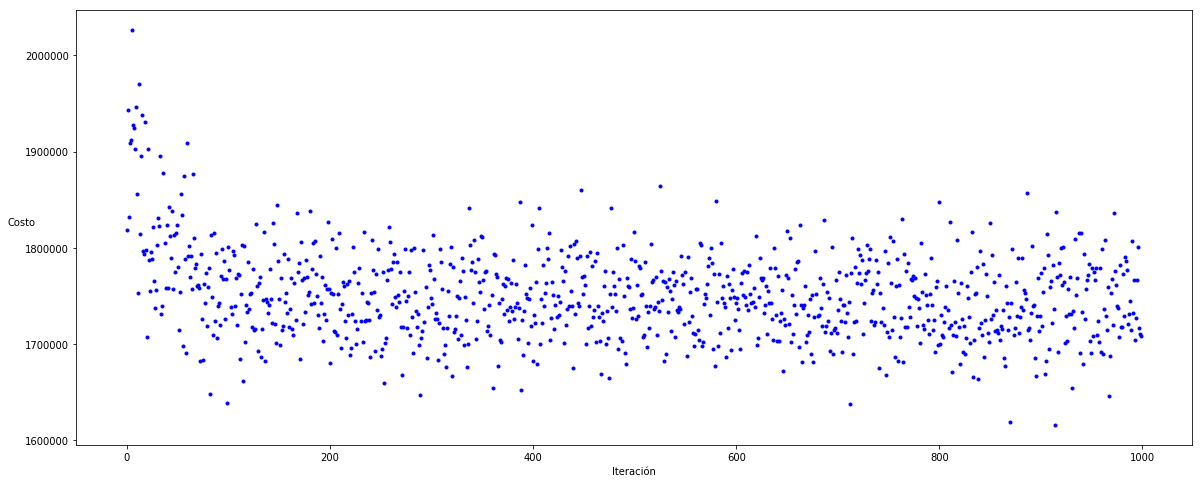

In [105]:
plot_SGD(iteraciones,costos)

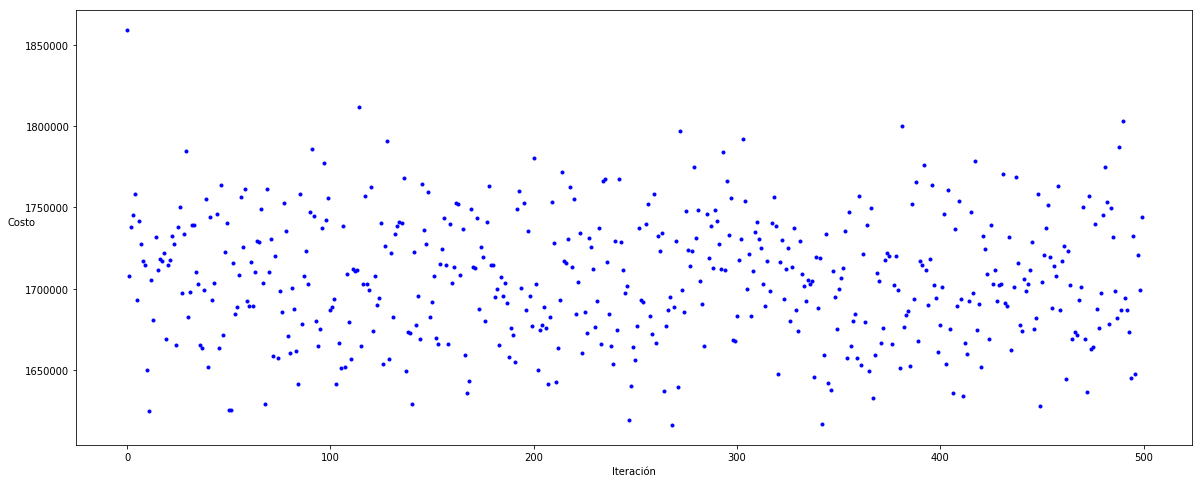

In [106]:
iteraciones = 500
eta = 0.5
_, costos = SGD(X_train, y_train, b0, eta, iteraciones)
plot_SGD(iteraciones,costos)

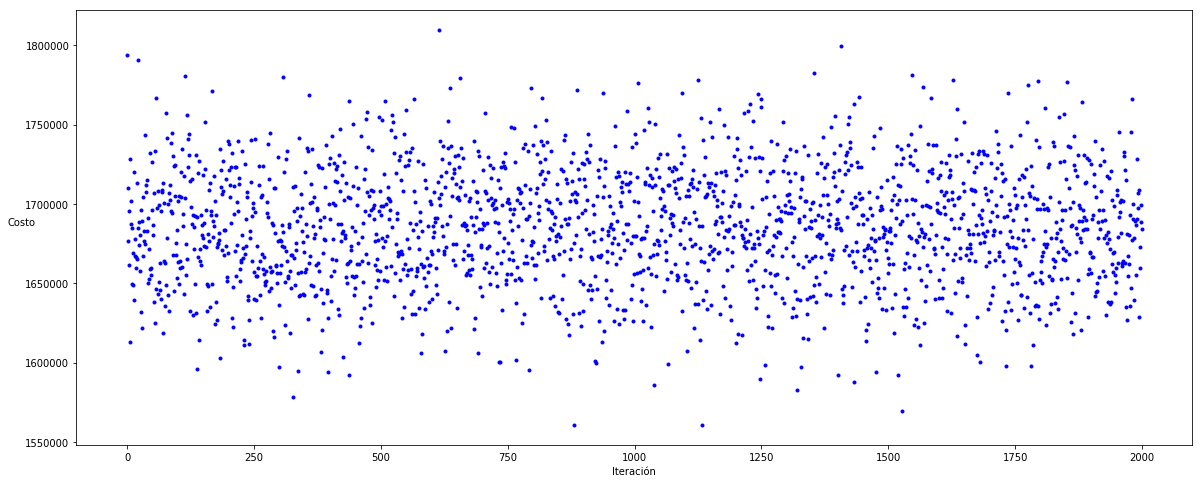

In [107]:
iteraciones = 2000
eta = 0.8
_, costos = SGD(X_train, y_train, b0, eta, iteraciones)
plot_SGD(iteraciones,costos)

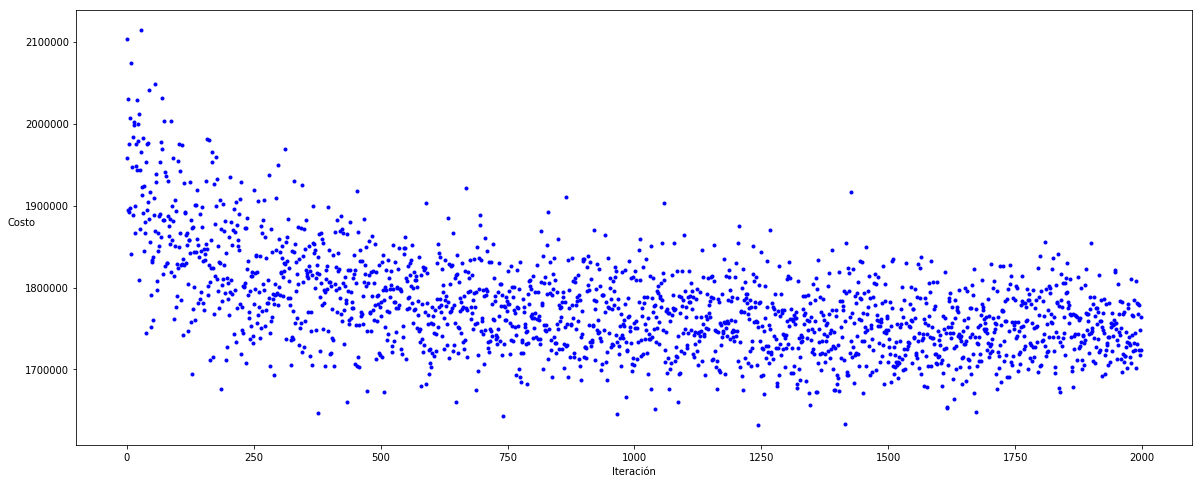

In [108]:
iteraciones = 2000
eta = 0.001
_, costos = SGD(X_train, y_train, b0, eta, iteraciones)
plot_SGD(iteraciones,costos)

Cuando las iteraciones son mayor a 1000 y con una tasa de aprendizaje pequeña se puede notar en los gráficos una relación entre el costo y el número de iteraciones donde el costo disminuye a medida que se hacen más iteraciones.